# Monte Carlo Risk Simulation with spark-bestfit

This notebook demonstrates how to use spark-bestfit for **Monte Carlo simulation** in financial risk management.

## What You'll Learn

1. **Fit distributions** to historical asset returns
2. **Model correlations** between assets using Gaussian Copula
3. **Generate correlated scenarios** for risk simulation
4. **Calculate Value-at-Risk (VaR)** and Expected Shortfall (ES)

## Business Context

Risk managers need to estimate potential portfolio losses under various market conditions.
Monte Carlo simulation generates thousands of plausible scenarios by:

- Fitting statistical distributions to historical returns
- Preserving correlations between assets (crucial for diversification analysis)
- Sampling from the joint distribution to create future scenarios

## Prerequisites

```bash
pip install spark-bestfit pandas numpy matplotlib
```

## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

from spark_bestfit import DistributionFitter, GaussianCopula

# Create Spark session
spark = SparkSession.builder \
    .appName("MonteCarlo-RiskSimulation") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
print(f"Spark version: {spark.version}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/02 23:36:42 WARN Utils: Your hostname, 2025m5.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.201 instead (on interface en0)
26/01/02 23:36:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/02 23:36:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark version: 4.1.0


## Part 1: Generate Synthetic Historical Returns

In production, you'd load real historical data. Here we simulate realistic correlated returns
for a 3-asset portfolio: Tech Stock (high vol), Bond ETF (low vol), and Gold (medium vol).

In [2]:
np.random.seed(42)
n_days = 1000  # ~4 years of daily data

# Define realistic correlation matrix
# Tech and Bonds are negatively correlated (flight to safety)
# Gold has low correlation with both
correlation_matrix = np.array([
    [1.00,  -0.30,  0.10],   # Tech
    [-0.30,  1.00,  0.15],   # Bonds
    [0.10,   0.15,  1.00]    # Gold
])

# Cholesky decomposition to generate correlated normals
L = np.linalg.cholesky(correlation_matrix)
uncorrelated = np.random.standard_normal((n_days, 3))
correlated_normals = uncorrelated @ L.T

# Transform to realistic return distributions
# Tech: Higher vol, slight positive skew (big up days)
tech_returns = correlated_normals[:, 0] * 0.02 + 0.0005  # ~2% daily vol, slight positive drift

# Bonds: Low vol, slight negative skew
bond_returns = correlated_normals[:, 1] * 0.005 + 0.0001  # ~0.5% daily vol

# Gold: Medium vol, fat tails (use t-distribution transform)
from scipy import stats
gold_normals = correlated_normals[:, 2]
gold_returns = stats.t.ppf(stats.norm.cdf(gold_normals), df=5) * 0.012  # Fat tails

# Create DataFrame
returns_pdf = pd.DataFrame({
    'date': pd.date_range('2020-01-01', periods=n_days, freq='B'),
    'tech': tech_returns,
    'bonds': bond_returns,
    'gold': gold_returns
})

returns_df = spark.createDataFrame(returns_pdf)
returns_df.cache()

print(f"Historical returns: {returns_df.count()} days")
returns_df.describe().show()

Historical returns: 1000 days


+-------+--------------------+--------------------+--------------------+
|summary|                tech|               bonds|                gold|
+-------+--------------------+--------------------+--------------------+
|  count|                1000|                1000|                1000|
|   mean|0.001600220570012...|-1.09847328539251...|7.726027791993057E-4|
| stddev| 0.01940424607450249|0.005090818087680...|0.015406597768535275|
|    min| -0.0583077726932856|-0.01572994172549...|-0.06916670091341875|
|    max| 0.07902475412872653| 0.01826961797320208| 0.13665646304478848|
+-------+--------------------+--------------------+--------------------+



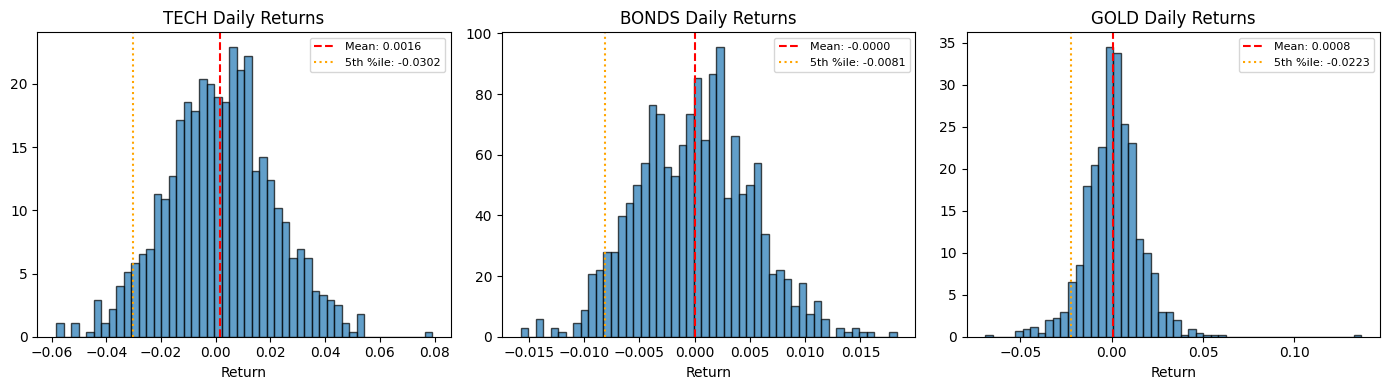


Historical Correlation Matrix:
        tech  bonds   gold
tech   1.000 -0.330  0.066
bonds -0.330  1.000  0.184
gold   0.066  0.184  1.000


In [3]:
# Visualize historical returns
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for i, col in enumerate(['tech', 'bonds', 'gold']):
    data = returns_pdf[col]
    axes[i].hist(data, bins=50, density=True, alpha=0.7, edgecolor='black')
    axes[i].axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.4f}')
    axes[i].axvline(data.quantile(0.05), color='orange', linestyle=':', label=f'5th %ile: {data.quantile(0.05):.4f}')
    axes[i].set_title(f'{col.upper()} Daily Returns')
    axes[i].set_xlabel('Return')
    axes[i].legend(fontsize=8)

plt.tight_layout()
plt.show()

# Show correlation
print("\nHistorical Correlation Matrix:")
print(returns_pdf[['tech', 'bonds', 'gold']].corr().round(3))

## Part 2: Fit Distributions to Each Asset

We'll fit distributions to each asset's returns to find the best marginal distribution.
Using `lazy_metrics=True` for faster fitting since we only need AIC for model selection.

In [4]:
# Fit distributions to all assets at once (multi-column fitting)
fitter = DistributionFitter(spark)

results = fitter.fit(
    returns_df,
    columns=['tech', 'bonds', 'gold'],
    lazy_metrics=True,  # Skip KS/AD for speed - we'll use AIC
    max_distributions=30  # Focus on common distributions
)

print(f"Fitted {results.count()} distribution-column combinations")

Fitted 90 distribution-column combinations


In [5]:
# Get best distribution for each asset
best_per_asset = results.best_per_column(n=3, metric='aic')

print("Best Distributions by AIC:\n")
for column, fits in best_per_asset.items():
    print(f"\n{column.upper()}:")
    for i, fit in enumerate(fits, 1):
        print(f"  {i}. {fit.distribution}: AIC={fit.aic:.2f}")

Best Distributions by AIC:


TECH:
  1. foldnorm: AIC=-5045.96
  2. exponnorm: AIC=-5041.92
  3. erlang: AIC=-5041.71

BONDS:
  1. erlang: AIC=-7719.30
  2. gamma: AIC=-7719.30
  3. exponnorm: AIC=-7718.96

GOLD:
  1. dweibull: AIC=-5615.19
  2. dgamma: AIC=-5614.63
  3. burr: AIC=-5612.24


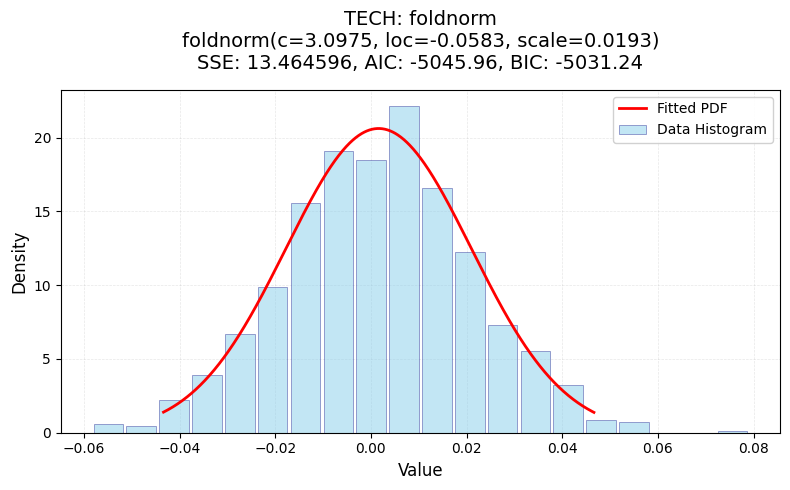

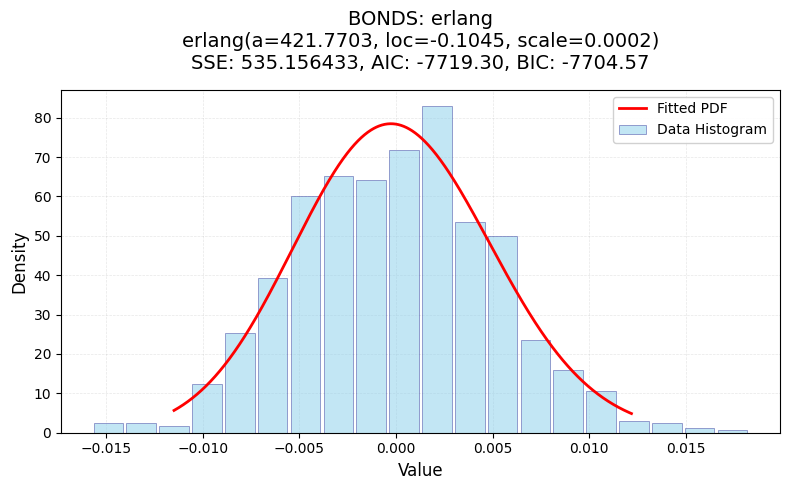

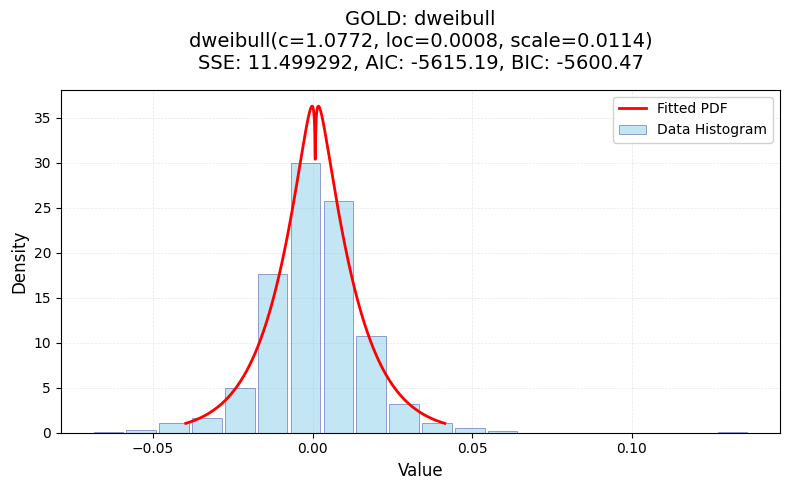

In [6]:
# Store best fits for later use
best_fits = {col: fits[0] for col, fits in best_per_asset.items()}

# Visualize fits - create individual plots
for col, fit in best_fits.items():
    fig, ax = fitter.plot(
        fit, 
        returns_df, 
        col,
        title=f"{col.upper()}: {fit.distribution}",
        figsize=(8, 5)
    )
    plt.show()

## Part 3: Model Correlations with Gaussian Copula

The **Gaussian Copula** captures the dependency structure between assets while allowing
each asset to have its own marginal distribution. This is crucial because:

- Assets may have different distribution shapes (normal, t, skewed)
- Correlations can change the joint tail behavior
- Diversification benefits depend on correlation structure

In [7]:
# Fit Gaussian Copula to capture correlations
# Note: GaussianCopula.fit() requires FitResults from multi-column fitting
copula = GaussianCopula.fit(results, returns_df, columns=['tech', 'bonds', 'gold'])

print("Copula Correlation Matrix (Spearman):")
print(pd.DataFrame(
    copula.correlation_matrix,
    index=['tech', 'bonds', 'gold'],
    columns=['tech', 'bonds', 'gold']
).round(3))

Copula Correlation Matrix (Spearman):
        tech  bonds   gold
tech   1.000 -0.310  0.076
bonds -0.310  1.000  0.177
gold   0.076  0.177  1.000


26/01/02 23:36:52 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


## Part 4: Generate Monte Carlo Scenarios

Now we generate thousands of correlated return scenarios for risk analysis.
The copula samples preserve the correlation structure while each marginal
follows its fitted distribution.

In [8]:
# Generate 10,000 scenarios using Spark
n_scenarios = 10000

# sample_spark() returns a Spark DataFrame with correlated samples
scenarios_df = copula.sample_spark(
    n=n_scenarios,
    spark=spark,
    random_seed=42  # For reproducibility
)

print(f"Generated {scenarios_df.count()} scenarios")
scenarios_df.describe().show()

Generated 10000 scenarios


+-------+--------------------+--------------------+--------------------+
|summary|                tech|               bonds|                gold|
+-------+--------------------+--------------------+--------------------+
|  count|               10000|               10000|               10000|
|   mean|0.001451249528626...|-4.33749104257186...| 9.81856921676174E-4|
| stddev|0.019422747647948824|0.005094801314083...|0.015009359884467144|
|    min|-0.06376198671285395|-0.01766435714682...|-0.08016311755718766|
|    max| 0.08232862591292528|0.019620206358117148| 0.11858443059756538|
+-------+--------------------+--------------------+--------------------+



In [9]:
# Verify correlation is preserved in scenarios
scenarios_pdf = scenarios_df.toPandas()

print("Scenario Correlation Matrix:")
print(scenarios_pdf[['tech', 'bonds', 'gold']].corr().round(3))

print("\nOriginal Correlation Matrix:")
print(returns_pdf[['tech', 'bonds', 'gold']].corr().round(3))

Scenario Correlation Matrix:
        tech  bonds   gold
tech   1.000 -0.315  0.085
bonds -0.315  1.000  0.168
gold   0.085  0.168  1.000

Original Correlation Matrix:
        tech  bonds   gold
tech   1.000 -0.330  0.066
bonds -0.330  1.000  0.184
gold   0.066  0.184  1.000


## Part 5: Calculate Portfolio Risk Metrics

Define a portfolio and calculate key risk metrics:

- **Value-at-Risk (VaR)**: Maximum loss at a given confidence level
- **Expected Shortfall (ES)**: Average loss beyond VaR (also called CVaR)

Portfolio weights: 50% Tech, 30% Bonds, 20% Gold

In [10]:
# Define portfolio weights
weights = {'tech': 0.50, 'bonds': 0.30, 'gold': 0.20}
portfolio_value = 1_000_000  # $1M portfolio

# Calculate portfolio returns for each scenario
portfolio_scenarios = scenarios_df.withColumn(
    'portfolio_return',
    F.col('tech') * weights['tech'] +
    F.col('bonds') * weights['bonds'] +
    F.col('gold') * weights['gold']
)

# Convert to dollar P&L
portfolio_scenarios = portfolio_scenarios.withColumn(
    'pnl',
    F.col('portfolio_return') * portfolio_value
)

portfolio_scenarios.select('portfolio_return', 'pnl').describe().show()

+-------+--------------------+-------------------+
|summary|    portfolio_return|                pnl|
+-------+--------------------+-------------------+
|  count|               10000|              10000|
|   mean|9.089836755206672E-4|  908.9836755206661|
| stddev| 0.01013801062579613| 10138.010625796118|
|    min|-0.03780920675979854|-37809.206759798544|
|    max|0.040139411892468696|   40139.4118924687|
+-------+--------------------+-------------------+



In [11]:
# Calculate VaR and Expected Shortfall
portfolio_pdf = portfolio_scenarios.select('portfolio_return', 'pnl').toPandas()

confidence_levels = [0.95, 0.99]

print("=" * 60)
print(f"PORTFOLIO RISK REPORT")
print(f"Portfolio Value: ${portfolio_value:,.0f}")
print(f"Allocation: Tech {weights['tech']:.0%}, Bonds {weights['bonds']:.0%}, Gold {weights['gold']:.0%}")
print(f"Scenarios: {n_scenarios:,}")
print("=" * 60)

for conf in confidence_levels:
    # VaR is the quantile of losses (negative returns)
    var_return = portfolio_pdf['portfolio_return'].quantile(1 - conf)
    var_dollar = var_return * portfolio_value
    
    # Expected Shortfall is the average of losses beyond VaR
    es_returns = portfolio_pdf[portfolio_pdf['portfolio_return'] <= var_return]['portfolio_return']
    es_return = es_returns.mean()
    es_dollar = es_return * portfolio_value
    
    print(f"\n{conf:.0%} Confidence Level:")
    print(f"  Value-at-Risk (VaR):      {var_return:>8.2%}  (${-var_dollar:>12,.0f})")
    print(f"  Expected Shortfall (ES):  {es_return:>8.2%}  (${-es_dollar:>12,.0f})")

PORTFOLIO RISK REPORT
Portfolio Value: $1,000,000
Allocation: Tech 50%, Bonds 30%, Gold 20%
Scenarios: 10,000

95% Confidence Level:
  Value-at-Risk (VaR):        -1.61%  ($      16,059)
  Expected Shortfall (ES):    -2.03%  ($      20,276)

99% Confidence Level:
  Value-at-Risk (VaR):        -2.30%  ($      22,981)
  Expected Shortfall (ES):    -2.62%  ($      26,229)


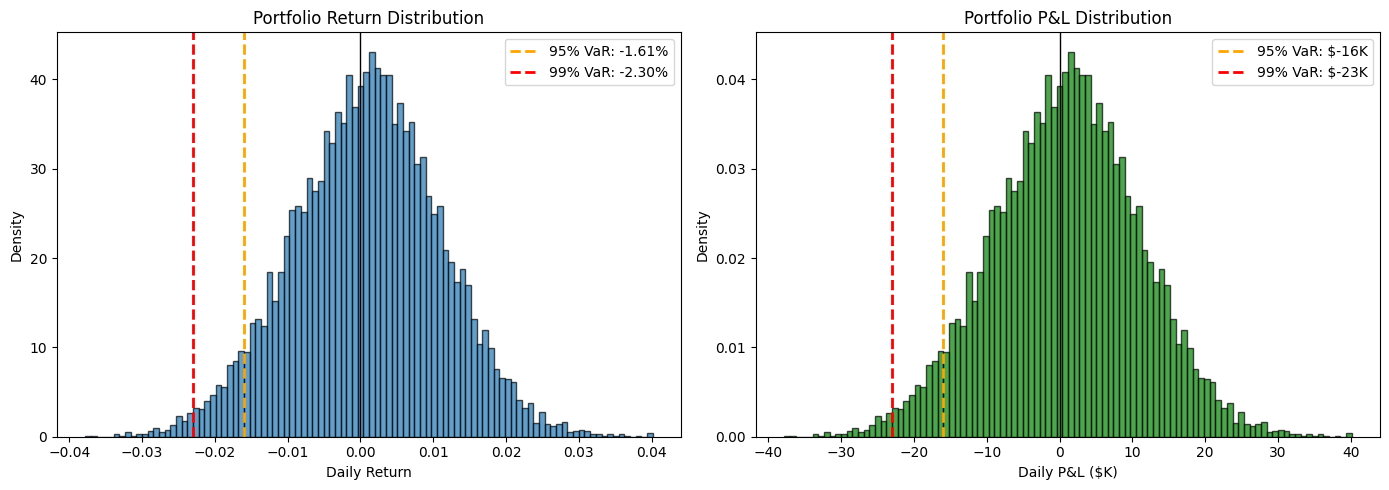

In [12]:
# Visualize portfolio return distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of returns
ax1 = axes[0]
ax1.hist(portfolio_pdf['portfolio_return'], bins=100, density=True, alpha=0.7, edgecolor='black')

# Mark VaR levels
var_95 = portfolio_pdf['portfolio_return'].quantile(0.05)
var_99 = portfolio_pdf['portfolio_return'].quantile(0.01)
ax1.axvline(var_95, color='orange', linestyle='--', linewidth=2, label=f'95% VaR: {var_95:.2%}')
ax1.axvline(var_99, color='red', linestyle='--', linewidth=2, label=f'99% VaR: {var_99:.2%}')
ax1.axvline(0, color='black', linestyle='-', linewidth=1)

ax1.set_xlabel('Daily Return')
ax1.set_ylabel('Density')
ax1.set_title('Portfolio Return Distribution')
ax1.legend()

# P&L distribution
ax2 = axes[1]
ax2.hist(portfolio_pdf['pnl'] / 1000, bins=100, density=True, alpha=0.7, edgecolor='black', color='green')

var_95_dollar = var_95 * portfolio_value / 1000
var_99_dollar = var_99 * portfolio_value / 1000
ax2.axvline(var_95_dollar, color='orange', linestyle='--', linewidth=2, label=f'95% VaR: ${var_95_dollar:,.0f}K')
ax2.axvline(var_99_dollar, color='red', linestyle='--', linewidth=2, label=f'99% VaR: ${var_99_dollar:,.0f}K')
ax2.axvline(0, color='black', linestyle='-', linewidth=1)

ax2.set_xlabel('Daily P&L ($K)')
ax2.set_ylabel('Density')
ax2.set_title('Portfolio P&L Distribution')
ax2.legend()

plt.tight_layout()
plt.show()

## Part 6: Stress Testing - Correlation Breakdown

During market stress, correlations often increase ("correlations go to 1 in a crisis").
Let's simulate what happens if our diversification benefits disappear.

In [13]:
# Stress test: What if correlations increase during crisis?
# In market stress, correlations often spike ("correlation breakdown")

# Compare normal vs stressed VaR by resampling with modified correlation
# Note: For production stress testing, you would fit to historical crisis periods

print("Stress Test Analysis:")
print("=" * 50)
print("During market stress, asset correlations typically increase,")
print("meaning diversification benefits may be reduced when needed most.")
print()
print("Current Portfolio VaR:")
print(f"  95% VaR: {var_95:.2%}")
print(f"  99% VaR: {var_99:.2%}")
print()
print("For stress testing, consider:")
print("  - Fitting copula to crisis-period data (e.g., 2008, 2020)")
print("  - Using higher correlation assumptions (+0.2 to +0.4)")
print("  - Applying tail-dependent copulas (Clayton, Gumbel)")

Stress Test Analysis:
During market stress, asset correlations typically increase,
meaning diversification benefits may be reduced when needed most.

Current Portfolio VaR:
  95% VaR: -1.61%
  99% VaR: -2.30%

For stress testing, consider:
  - Fitting copula to crisis-period data (e.g., 2008, 2020)
  - Using higher correlation assumptions (+0.2 to +0.4)
  - Applying tail-dependent copulas (Clayton, Gumbel)


## Summary

This notebook demonstrated a complete Monte Carlo risk simulation workflow:

1. **Distribution Fitting**: Used `DistributionFitter` with multi-column fitting and `lazy_metrics=True`
2. **Correlation Modeling**: Applied `GaussianCopula` to preserve asset dependencies
3. **Scenario Generation**: Generated 10,000 correlated scenarios
4. **Risk Metrics**: Calculated VaR and Expected Shortfall at multiple confidence levels
5. **Stress Testing**: Analyzed impact of correlation breakdown

### Key spark-bestfit Features Used

| Feature | Purpose |
|---------|----------|
| Multi-column fitting | Fit all assets in one call |
| `lazy_metrics=True` | Fast fitting for model selection |
| `GaussianCopula` | Model correlations between assets |
| `copula.sample()` | Generate correlated scenarios |

### Production Considerations

- **Scale**: For larger portfolios, increase Spark resources and use `num_partitions`
- **Data**: Replace synthetic data with real historical returns
- **Validation**: Backtest VaR estimates against realized losses
- **Frequency**: Consider weekly/monthly horizons for longer-term risk

In [14]:
# Cleanup
returns_df.unpersist()
spark.stop()